# Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [2]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask)


# Masking

In [3]:
def masking (depth, temp, saline, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    return (temp, saline)


# SOM

In [4]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [5]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [6]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 15068 

The minimum temperature for cluster 0 is 7.79 degrees Celsius
The maximum temperature for cluster 0 is 9.73 degrees Celsius
The mean temperature for cluster 0 is 8.61 degrees Celsius 

The minimum salinity for cluster 0 is 27.3 g/kg
The maximum salinity for cluster 0 is 30.67 g/kg
The mean salinity for cluster 0 is 28.28 g/kg 


The amount of grid boxes for cluster 1 is 27432 

The minimum temperature for cluster 1 is 6.81 degrees Celsius
The maximum temperature for cluster 1 is 8.96 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 27.58 g/kg
The maximum salinity for cluster 1 is 31.32 g/kg
The mean salinity for cluster 1 is 30.29 g/kg 


The amount of grid boxes for cluster 2 is 15766 

The minimum temperature for cluster 2 is 8.72 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 9.09 degrees Celsius 

Th

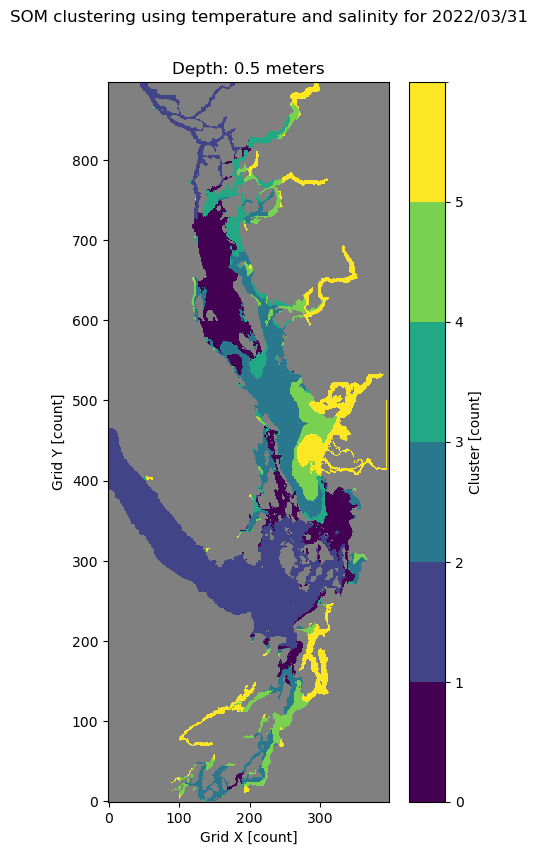

The amount of grid boxes for cluster 0 is 10212 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.16 degrees Celsius
The mean temperature for cluster 0 is 9.11 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 23.03 g/kg
The mean salinity for cluster 0 is 17.92 g/kg 


The amount of grid boxes for cluster 1 is 8463 

The minimum temperature for cluster 1 is 7.83 degrees Celsius
The maximum temperature for cluster 1 is 10.54 degrees Celsius
The mean temperature for cluster 1 is 9.24 degrees Celsius 

The minimum salinity for cluster 1 is 22.34 g/kg
The maximum salinity for cluster 1 is 26.31 g/kg
The mean salinity for cluster 1 is 24.43 g/kg 


The amount of grid boxes for cluster 2 is 6316 

The minimum temperature for cluster 2 is 7.5 degrees Celsius
The maximum temperature for cluster 2 is 8.69 degrees Celsius
The mean temperature for cluster 2 is 8.44 degrees Celsius 

The 

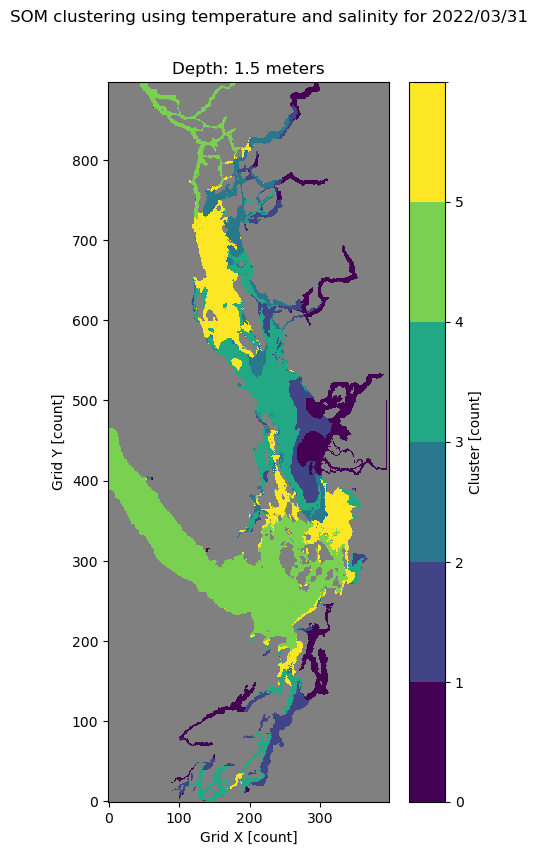

The amount of grid boxes for cluster 0 is 8036 

The minimum temperature for cluster 0 is 7.53 degrees Celsius
The maximum temperature for cluster 0 is 9.39 degrees Celsius
The mean temperature for cluster 0 is 8.33 degrees Celsius 

The minimum salinity for cluster 0 is 27.5 g/kg
The maximum salinity for cluster 0 is 30.67 g/kg
The mean salinity for cluster 0 is 28.83 g/kg 


The amount of grid boxes for cluster 1 is 26020 

The minimum temperature for cluster 1 is 6.73 degrees Celsius
The maximum temperature for cluster 1 is 8.96 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 28.7 g/kg
The maximum salinity for cluster 1 is 31.32 g/kg
The mean salinity for cluster 1 is 30.39 g/kg 


The amount of grid boxes for cluster 2 is 13628 

The minimum temperature for cluster 2 is 7.59 degrees Celsius
The maximum temperature for cluster 2 is 9.98 degrees Celsius
The mean temperature for cluster 2 is 8.71 degrees Celsius 

The 

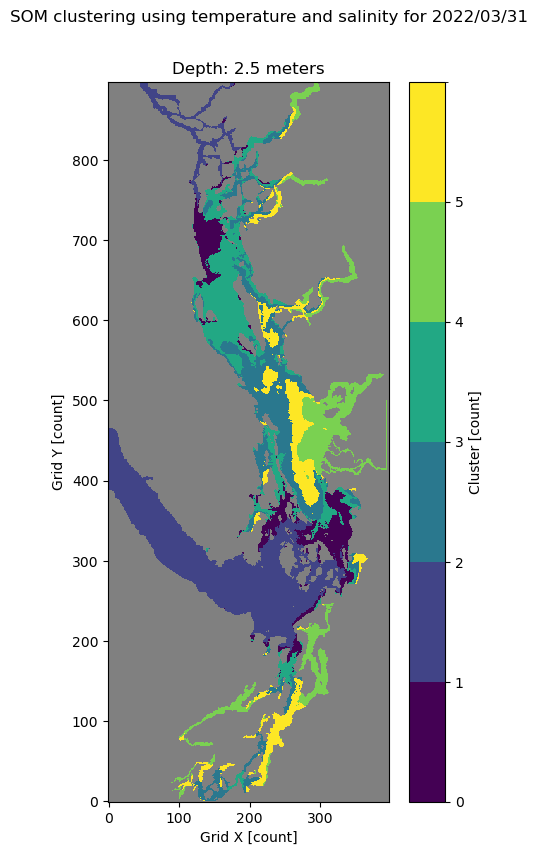

The amount of grid boxes for cluster 0 is 8278 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.84 degrees Celsius
The mean temperature for cluster 0 is 8.77 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.37 g/kg
The mean salinity for cluster 0 is 20.51 g/kg 


The amount of grid boxes for cluster 1 is 12761 

The minimum temperature for cluster 1 is 8.31 degrees Celsius
The maximum temperature for cluster 1 is 10.52 degrees Celsius
The mean temperature for cluster 1 is 9.07 degrees Celsius 

The minimum salinity for cluster 1 is 24.25 g/kg
The maximum salinity for cluster 1 is 28.8 g/kg
The mean salinity for cluster 1 is 26.44 g/kg 


The amount of grid boxes for cluster 2 is 12225 

The minimum temperature for cluster 2 is 7.43 degrees Celsius
The maximum temperature for cluster 2 is 8.8 degrees Celsius
The mean temperature for cluster 2 is 8.26 degrees Celsius 

The 

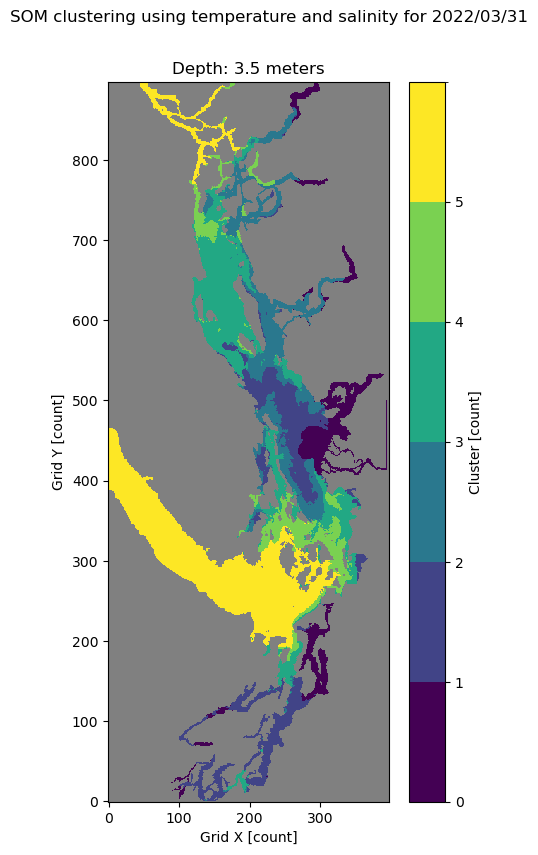

The amount of grid boxes for cluster 0 is 14020 

The minimum temperature for cluster 0 is 8.34 degrees Celsius
The maximum temperature for cluster 0 is 10.47 degrees Celsius
The mean temperature for cluster 0 is 8.84 degrees Celsius 

The minimum salinity for cluster 0 is 25.31 g/kg
The maximum salinity for cluster 0 is 29.84 g/kg
The mean salinity for cluster 0 is 27.2 g/kg 


The amount of grid boxes for cluster 1 is 8699 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 8.66 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 26.74 g/kg
The mean salinity for cluster 1 is 22.77 g/kg 


The amount of grid boxes for cluster 2 is 14210 

The minimum temperature for cluster 2 is 8.03 degrees Celsius
The maximum temperature for cluster 2 is 9.26 degrees Celsius
The mean temperature for cluster 2 is 8.37 degrees Celsius 

The

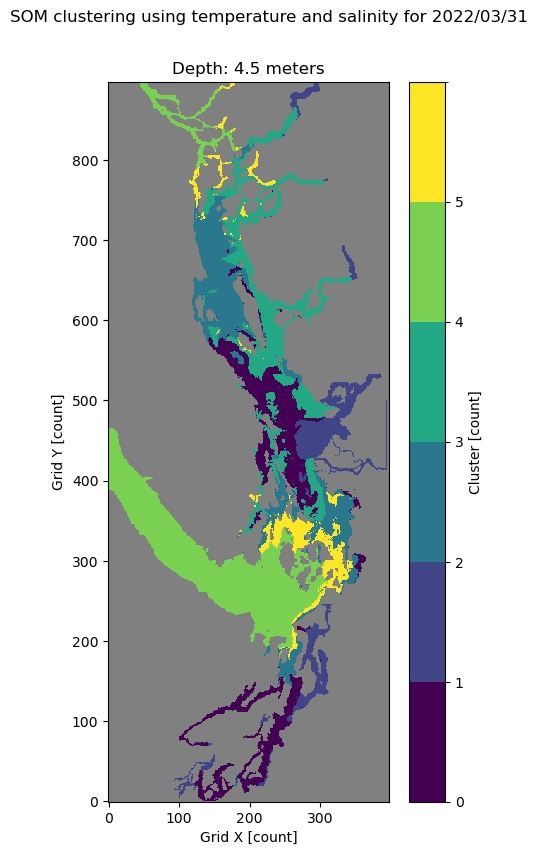

The amount of grid boxes for cluster 0 is 6454 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.24 degrees Celsius
The mean temperature for cluster 0 is 8.12 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.5 g/kg
The mean salinity for cluster 0 is 23.83 g/kg 


The amount of grid boxes for cluster 1 is 14685 

The minimum temperature for cluster 1 is 8.32 degrees Celsius
The maximum temperature for cluster 1 is 10.37 degrees Celsius
The mean temperature for cluster 1 is 8.85 degrees Celsius 

The minimum salinity for cluster 1 is 23.39 g/kg
The maximum salinity for cluster 1 is 29.67 g/kg
The mean salinity for cluster 1 is 27.1 g/kg 


The amount of grid boxes for cluster 2 is 12030 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.89 degrees Celsius 

The m

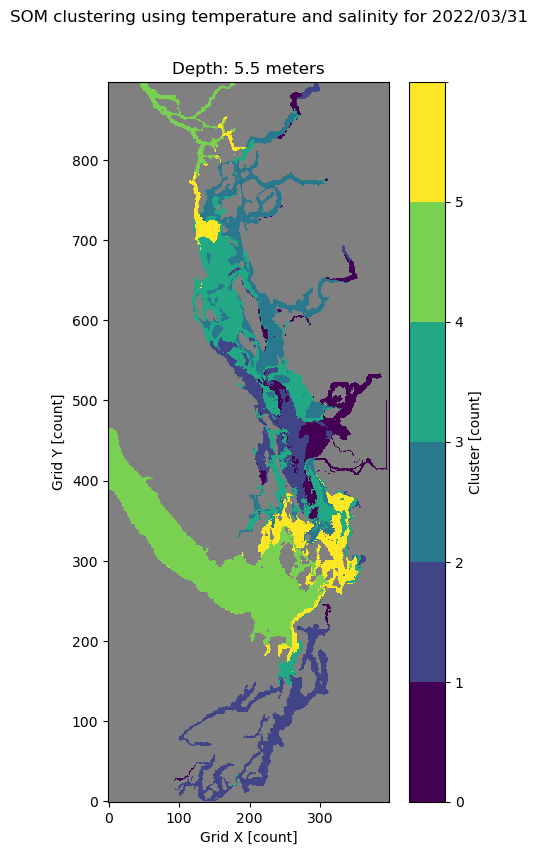

The amount of grid boxes for cluster 0 is 13380 

The minimum temperature for cluster 0 is 8.29 degrees Celsius
The maximum temperature for cluster 0 is 10.32 degrees Celsius
The mean temperature for cluster 0 is 8.8 degrees Celsius 

The minimum salinity for cluster 0 is 23.74 g/kg
The maximum salinity for cluster 0 is 29.85 g/kg
The mean salinity for cluster 0 is 27.52 g/kg 


The amount of grid boxes for cluster 1 is 7894 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.23 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.93 g/kg
The mean salinity for cluster 1 is 25.43 g/kg 


The amount of grid boxes for cluster 2 is 13107 

The minimum temperature for cluster 2 is 8.01 degrees Celsius
The maximum temperature for cluster 2 is 9.02 degrees Celsius
The mean temperature for cluster 2 is 8.26 degrees Celsius 

The 

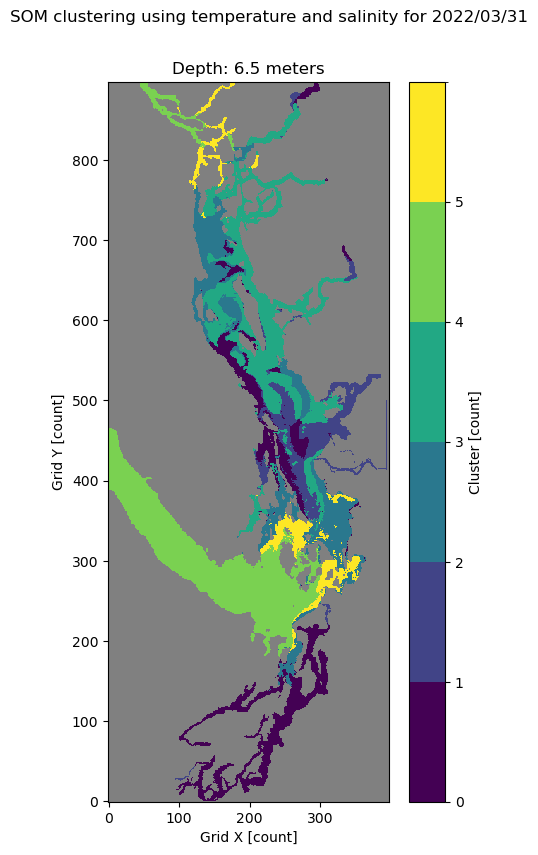

The amount of grid boxes for cluster 0 is 5489 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.22 degrees Celsius
The mean temperature for cluster 0 is 7.97 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.84 g/kg
The mean salinity for cluster 0 is 25.37 g/kg 


The amount of grid boxes for cluster 1 is 12777 

The minimum temperature for cluster 1 is 8.22 degrees Celsius
The maximum temperature for cluster 1 is 10.3 degrees Celsius
The mean temperature for cluster 1 is 8.75 degrees Celsius 

The minimum salinity for cluster 1 is 23.57 g/kg
The maximum salinity for cluster 1 is 29.85 g/kg
The mean salinity for cluster 1 is 27.69 g/kg 


The amount of grid boxes for cluster 2 is 15947 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 8.11 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The 

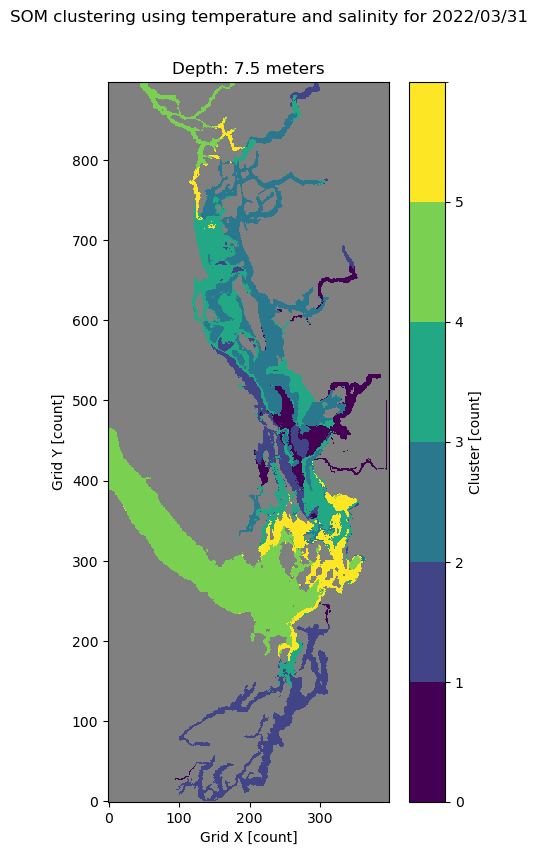

The amount of grid boxes for cluster 0 is 13518 

The minimum temperature for cluster 0 is 8.2 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.68 degrees Celsius 

The minimum salinity for cluster 0 is 22.44 g/kg
The maximum salinity for cluster 0 is 29.81 g/kg
The mean salinity for cluster 0 is 27.97 g/kg 


The amount of grid boxes for cluster 1 is 6705 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.09 degrees Celsius
The mean temperature for cluster 1 is 8.03 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.41 g/kg
The mean salinity for cluster 1 is 26.4 g/kg 


The amount of grid boxes for cluster 2 is 12584 

The minimum temperature for cluster 2 is 7.99 degrees Celsius
The maximum temperature for cluster 2 is 8.75 degrees Celsius
The mean temperature for cluster 2 is 8.18 degrees Celsius 

The m

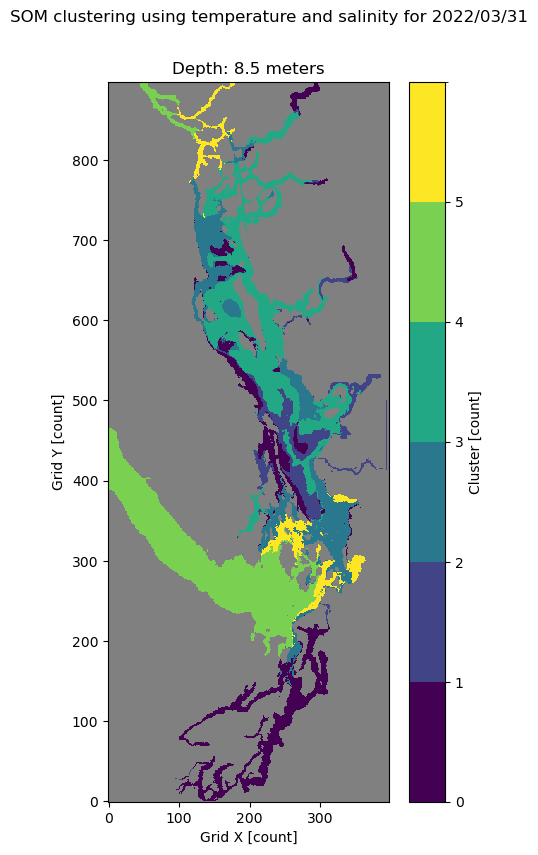

The amount of grid boxes for cluster 0 is 8967 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 8.77 degrees Celsius
The mean temperature for cluster 0 is 8.07 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.71 g/kg
The mean salinity for cluster 0 is 27.2 g/kg 


The amount of grid boxes for cluster 1 is 12038 

The minimum temperature for cluster 1 is 8.25 degrees Celsius
The maximum temperature for cluster 1 is 10.27 degrees Celsius
The mean temperature for cluster 1 is 8.71 degrees Celsius 

The minimum salinity for cluster 1 is 20.15 g/kg
The maximum salinity for cluster 1 is 29.83 g/kg
The mean salinity for cluster 1 is 28.11 g/kg 


The amount of grid boxes for cluster 2 is 19821 

The minimum temperature for cluster 2 is 7.39 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.89 degrees Celsius 

The 

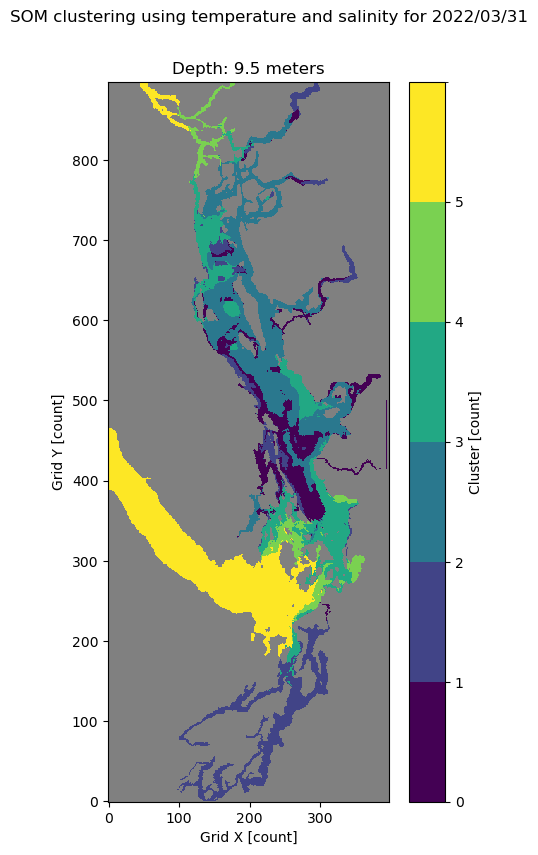

The amount of grid boxes for cluster 0 is 11809 

The minimum temperature for cluster 0 is 8.22 degrees Celsius
The maximum temperature for cluster 0 is 10.34 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 22.73 g/kg
The maximum salinity for cluster 0 is 29.84 g/kg
The mean salinity for cluster 0 is 28.27 g/kg 


The amount of grid boxes for cluster 1 is 6222 

The minimum temperature for cluster 1 is 6.38 degrees Celsius
The maximum temperature for cluster 1 is 9.13 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.72 g/kg
The mean salinity for cluster 1 is 27.28 g/kg 


The amount of grid boxes for cluster 2 is 12381 

The minimum temperature for cluster 2 is 7.95 degrees Celsius
The maximum temperature for cluster 2 is 8.45 degrees Celsius
The mean temperature for cluster 2 is 8.14 degrees Celsius 

The 

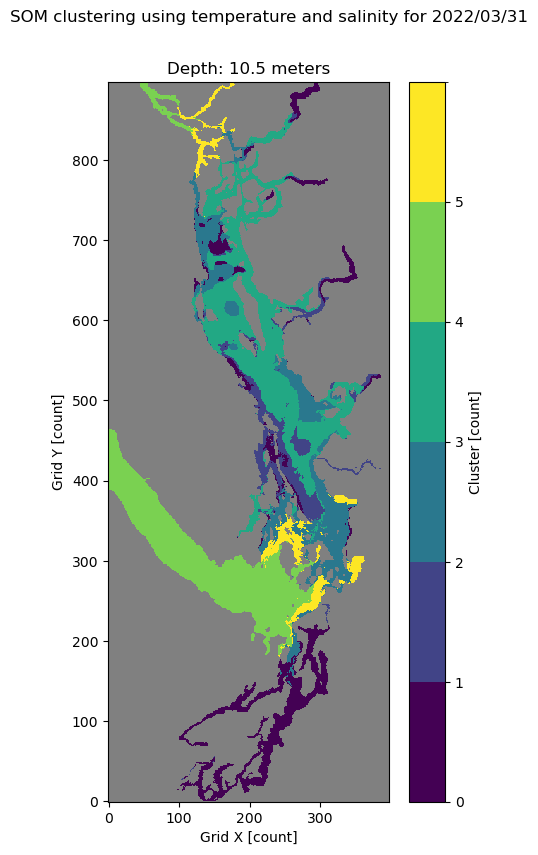

The amount of grid boxes for cluster 0 is 4564 

The minimum temperature for cluster 0 is 6.41 degrees Celsius
The maximum temperature for cluster 0 is 9.07 degrees Celsius
The mean temperature for cluster 0 is 8.06 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.67 g/kg
The mean salinity for cluster 0 is 27.17 g/kg 


The amount of grid boxes for cluster 1 is 12423 

The minimum temperature for cluster 1 is 8.2 degrees Celsius
The maximum temperature for cluster 1 is 10.43 degrees Celsius
The mean temperature for cluster 1 is 8.69 degrees Celsius 

The minimum salinity for cluster 1 is 22.61 g/kg
The maximum salinity for cluster 1 is 29.85 g/kg
The mean salinity for cluster 1 is 28.37 g/kg 


The amount of grid boxes for cluster 2 is 20154 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The 

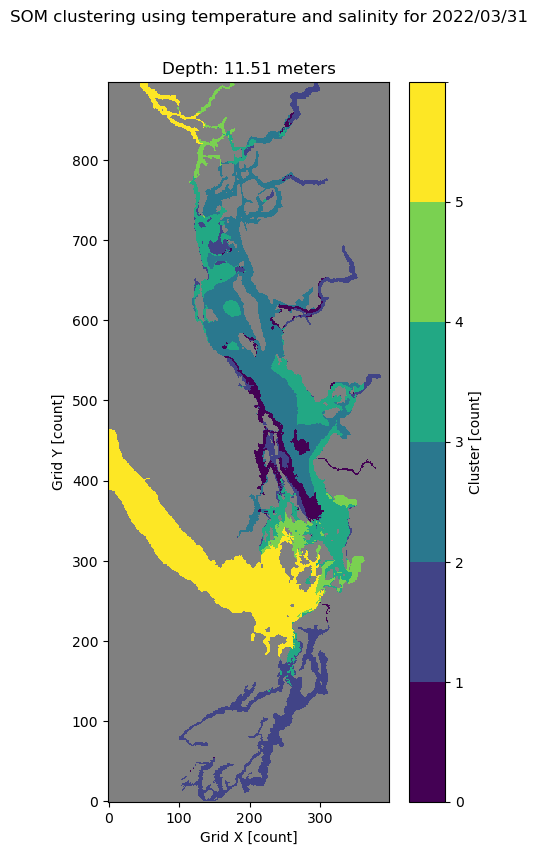

The amount of grid boxes for cluster 0 is 15662 

The minimum temperature for cluster 0 is 8.16 degrees Celsius
The maximum temperature for cluster 0 is 10.5 degrees Celsius
The mean temperature for cluster 0 is 8.61 degrees Celsius 

The minimum salinity for cluster 0 is 18.83 g/kg
The maximum salinity for cluster 0 is 29.86 g/kg
The mean salinity for cluster 0 is 28.53 g/kg 


The amount of grid boxes for cluster 1 is 1515 

The minimum temperature for cluster 1 is 8.04 degrees Celsius
The maximum temperature for cluster 1 is 8.45 degrees Celsius
The mean temperature for cluster 1 is 8.18 degrees Celsius 

The minimum salinity for cluster 1 is 29.18 g/kg
The maximum salinity for cluster 1 is 30.85 g/kg
The mean salinity for cluster 1 is 29.55 g/kg 


The amount of grid boxes for cluster 2 is 12414 

The minimum temperature for cluster 2 is 7.97 degrees Celsius
The maximum temperature for cluster 2 is 8.25 degrees Celsius
The mean temperature for cluster 2 is 8.11 degrees Celsius 

Th

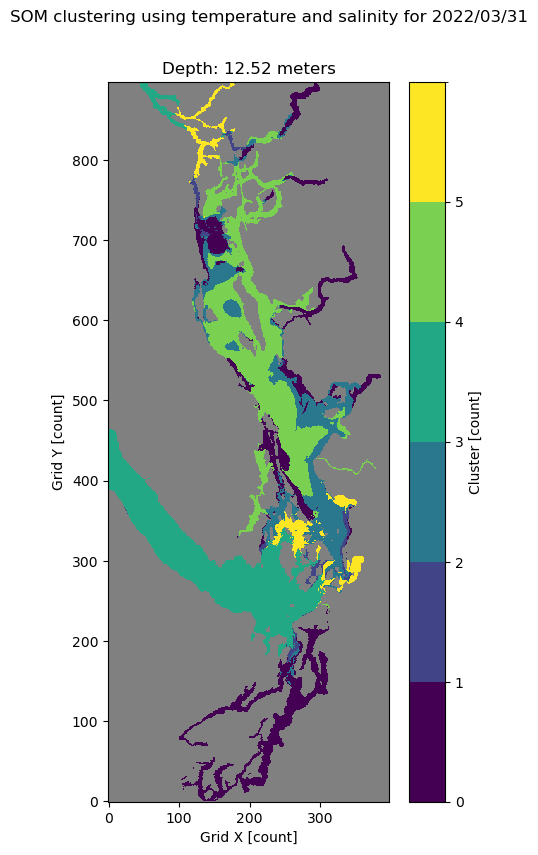

The amount of grid boxes for cluster 0 is 20218 

The minimum temperature for cluster 0 is 7.24 degrees Celsius
The maximum temperature for cluster 0 is 8.32 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 29.91 g/kg
The maximum salinity for cluster 0 is 31.68 g/kg
The mean salinity for cluster 0 is 30.75 g/kg 


The amount of grid boxes for cluster 1 is 4139 

The minimum temperature for cluster 1 is 6.56 degrees Celsius
The maximum temperature for cluster 1 is 8.05 degrees Celsius
The mean temperature for cluster 1 is 7.84 degrees Celsius 

The minimum salinity for cluster 1 is 29.17 g/kg
The maximum salinity for cluster 1 is 29.97 g/kg
The mean salinity for cluster 1 is 29.68 g/kg 


The amount of grid boxes for cluster 2 is 11265 

The minimum temperature for cluster 2 is 7.96 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.11 degrees Celsius 

The

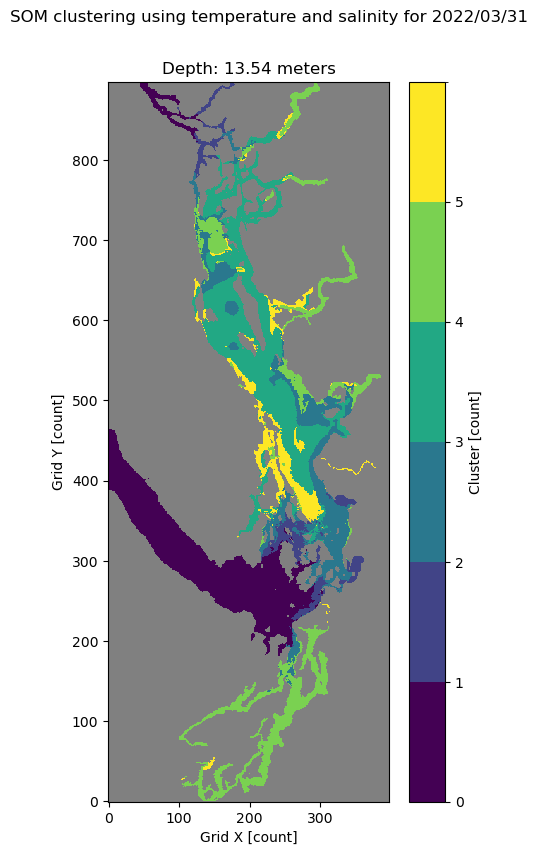

The amount of grid boxes for cluster 0 is 4157 

The minimum temperature for cluster 0 is 7.7 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 7.95 degrees Celsius 

The minimum salinity for cluster 0 is 29.46 g/kg
The maximum salinity for cluster 0 is 30.23 g/kg
The mean salinity for cluster 0 is 29.77 g/kg 


The amount of grid boxes for cluster 1 is 20194 

The minimum temperature for cluster 1 is 6.68 degrees Celsius
The maximum temperature for cluster 1 is 8.27 degrees Celsius
The mean temperature for cluster 1 is 7.82 degrees Celsius 

The minimum salinity for cluster 1 is 29.47 g/kg
The maximum salinity for cluster 1 is 31.73 g/kg
The mean salinity for cluster 1 is 30.75 g/kg 


The amount of grid boxes for cluster 2 is 11886 

The minimum temperature for cluster 2 is 8.03 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.16 degrees Celsius 

The 

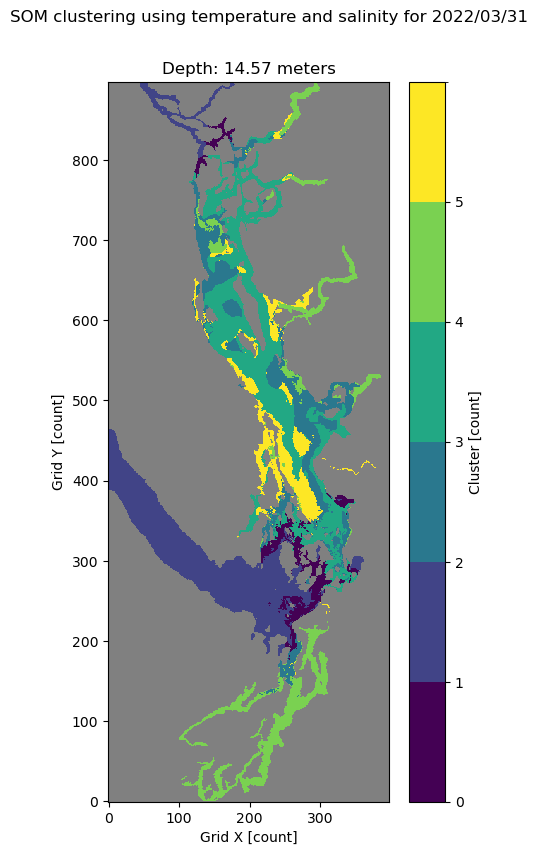

The amount of grid boxes for cluster 0 is 5964 

The minimum temperature for cluster 0 is 8.27 degrees Celsius
The maximum temperature for cluster 0 is 8.58 degrees Celsius
The mean temperature for cluster 0 is 8.34 degrees Celsius 

The minimum salinity for cluster 0 is 27.97 g/kg
The maximum salinity for cluster 0 is 29.87 g/kg
The mean salinity for cluster 0 is 29.1 g/kg 


The amount of grid boxes for cluster 1 is 8493 

The minimum temperature for cluster 1 is 8.38 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 8.94 degrees Celsius 

The minimum salinity for cluster 1 is 20.07 g/kg
The maximum salinity for cluster 1 is 29.88 g/kg
The mean salinity for cluster 1 is 28.62 g/kg 


The amount of grid boxes for cluster 2 is 4729 

The minimum temperature for cluster 2 is 7.92 degrees Celsius
The maximum temperature for cluster 2 is 8.31 degrees Celsius
The mean temperature for cluster 2 is 8.04 degrees Celsius 

The 

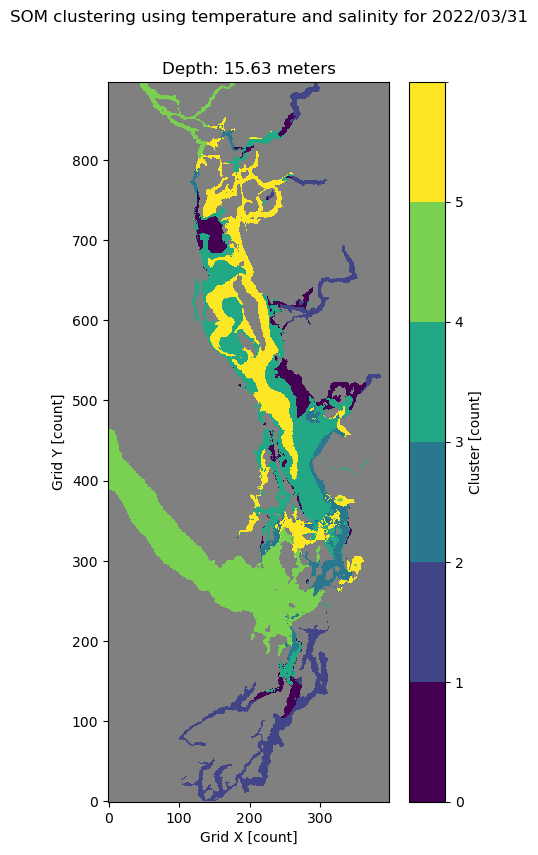

The amount of grid boxes for cluster 0 is 21771 

The minimum temperature for cluster 0 is 6.93 degrees Celsius
The maximum temperature for cluster 0 is 8.19 degrees Celsius
The mean temperature for cluster 0 is 7.81 degrees Celsius 

The minimum salinity for cluster 0 is 29.46 g/kg
The maximum salinity for cluster 0 is 31.83 g/kg
The mean salinity for cluster 0 is 30.71 g/kg 


The amount of grid boxes for cluster 1 is 628 

The minimum temperature for cluster 1 is 7.96 degrees Celsius
The maximum temperature for cluster 1 is 8.34 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 29.52 g/kg
The maximum salinity for cluster 1 is 30.99 g/kg
The mean salinity for cluster 1 is 29.86 g/kg 


The amount of grid boxes for cluster 2 is 11499 

The minimum temperature for cluster 2 is 7.71 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 8.04 degrees Celsius 

The 

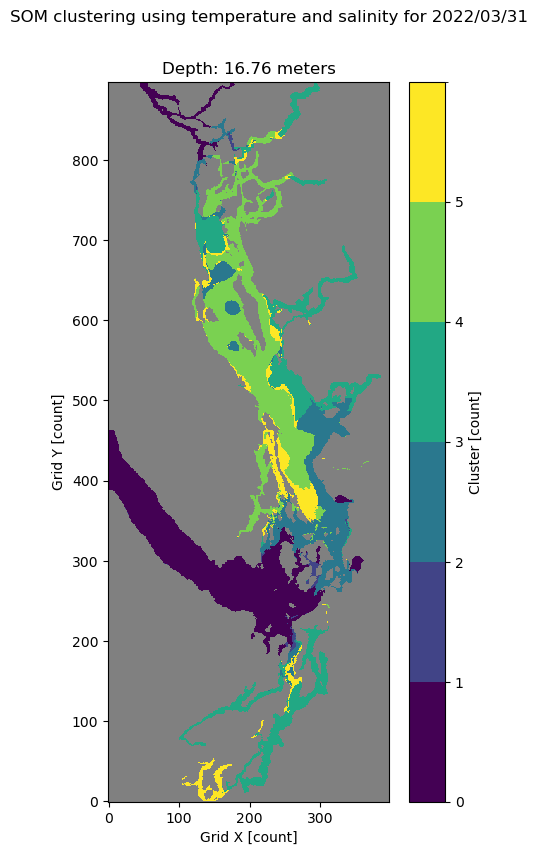

The amount of grid boxes for cluster 0 is 10359 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 8.34 degrees Celsius
The mean temperature for cluster 0 is 8.19 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.67 g/kg
The mean salinity for cluster 0 is 28.98 g/kg 


The amount of grid boxes for cluster 1 is 12882 

The minimum temperature for cluster 1 is 8.32 degrees Celsius
The maximum temperature for cluster 1 is 10.42 degrees Celsius
The mean temperature for cluster 1 is 8.78 degrees Celsius 

The minimum salinity for cluster 1 is 20.39 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 28.96 g/kg 


The amount of grid boxes for cluster 2 is 21673 

The minimum temperature for cluster 2 is 7.35 degrees Celsius
The maximum temperature for cluster 2 is 8.11 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

Th

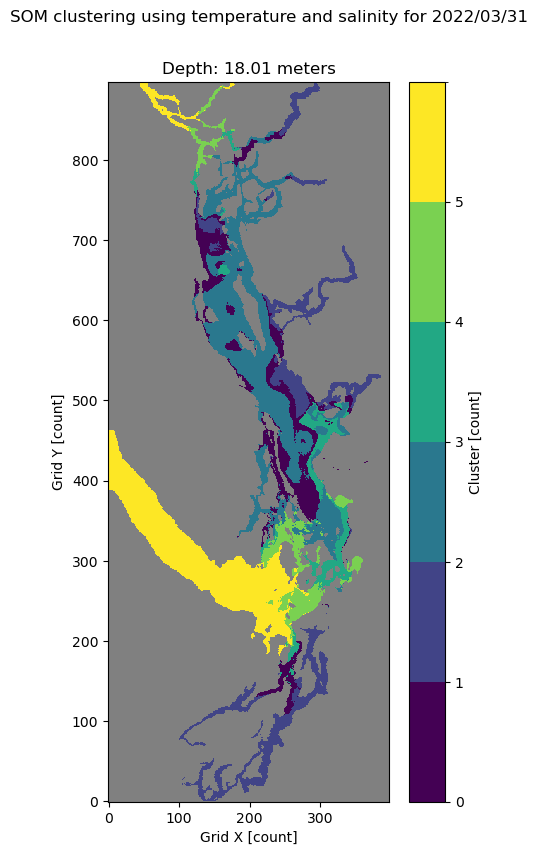

The amount of grid boxes for cluster 0 is 4015 

The minimum temperature for cluster 0 is 7.24 degrees Celsius
The maximum temperature for cluster 0 is 8.01 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 29.34 g/kg
The maximum salinity for cluster 0 is 30.15 g/kg
The mean salinity for cluster 0 is 29.74 g/kg 


The amount of grid boxes for cluster 1 is 20243 

The minimum temperature for cluster 1 is 6.49 degrees Celsius
The maximum temperature for cluster 1 is 8.23 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 29.5 g/kg
The mean salinity for cluster 1 is 28.92 g/kg 


The amount of grid boxes for cluster 2 is 19543 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 8.11 degrees Celsius
The mean temperature for cluster 2 is 7.79 degrees Celsius 

The m

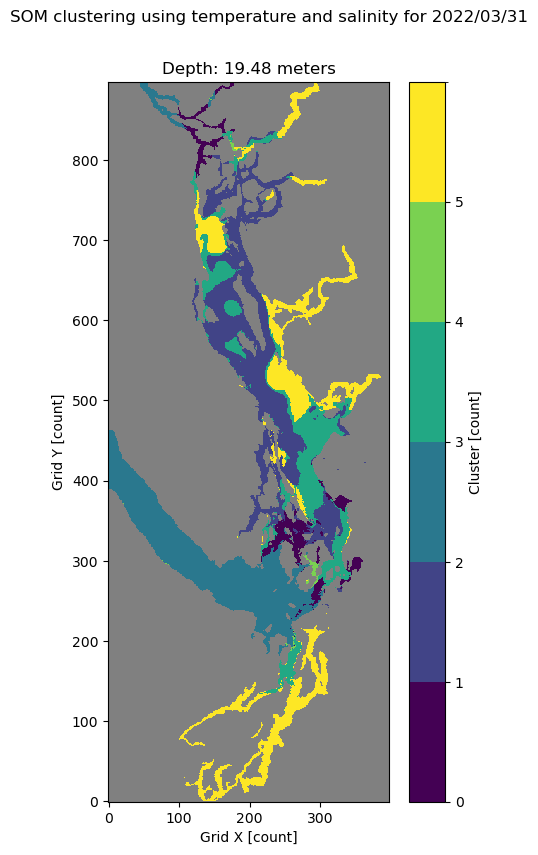

The amount of grid boxes for cluster 0 is 4729 

The minimum temperature for cluster 0 is 7.14 degrees Celsius
The maximum temperature for cluster 0 is 8.03 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.4 g/kg
The maximum salinity for cluster 0 is 30.75 g/kg
The mean salinity for cluster 0 is 29.86 g/kg 


The amount of grid boxes for cluster 1 is 20442 

The minimum temperature for cluster 1 is 7.34 degrees Celsius
The maximum temperature for cluster 1 is 8.23 degrees Celsius
The mean temperature for cluster 1 is 7.95 degrees Celsius 

The minimum salinity for cluster 1 is 27.44 g/kg
The maximum salinity for cluster 1 is 29.65 g/kg
The mean salinity for cluster 1 is 29.03 g/kg 


The amount of grid boxes for cluster 2 is 18311 

The minimum temperature for cluster 2 is 7.2 degrees Celsius
The maximum temperature for cluster 2 is 8.13 degrees Celsius
The mean temperature for cluster 2 is 7.78 degrees Celsius 

The 

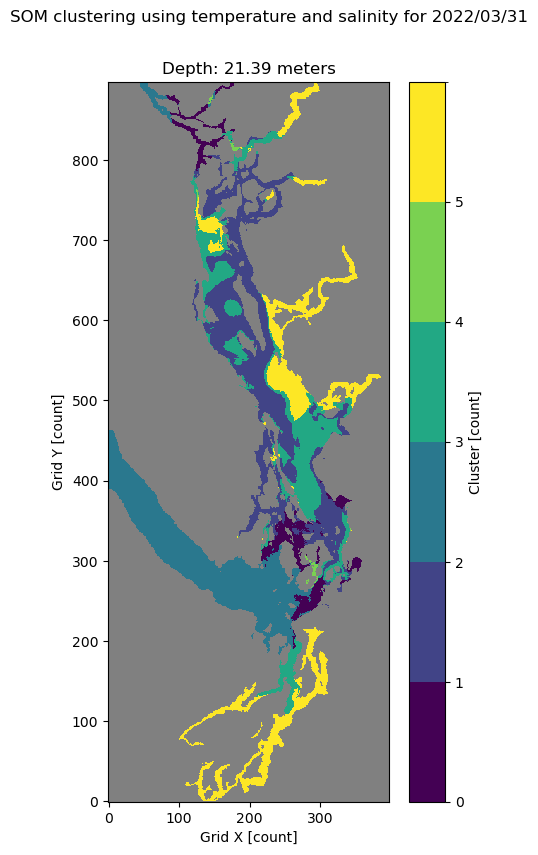

The amount of grid boxes for cluster 0 is 22068 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 8.18 degrees Celsius
The mean temperature for cluster 0 is 8.0 degrees Celsius 

The minimum salinity for cluster 0 is 28.18 g/kg
The maximum salinity for cluster 0 is 29.5 g/kg
The mean salinity for cluster 0 is 29.1 g/kg 


The amount of grid boxes for cluster 1 is 6724 

The minimum temperature for cluster 1 is 8.18 degrees Celsius
The maximum temperature for cluster 1 is 8.78 degrees Celsius
The mean temperature for cluster 1 is 8.3 degrees Celsius 

The minimum salinity for cluster 1 is 26.4 g/kg
The maximum salinity for cluster 1 is 29.7 g/kg
The mean salinity for cluster 1 is 28.99 g/kg 


The amount of grid boxes for cluster 2 is 7844 

The minimum temperature for cluster 2 is 7.77 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 8.02 degrees Celsius 

The minim

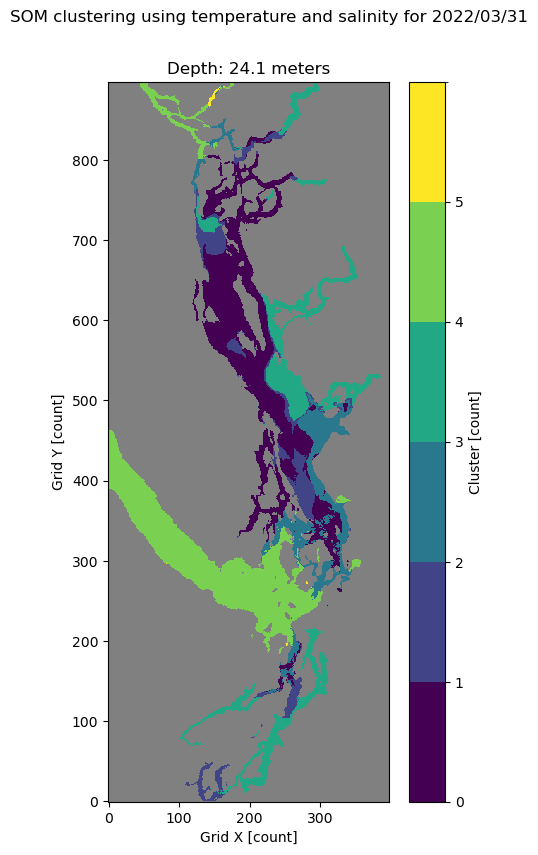

The amount of grid boxes for cluster 0 is 20145 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 8.06 degrees Celsius 

The minimum salinity for cluster 0 is 28.26 g/kg
The maximum salinity for cluster 0 is 29.64 g/kg
The mean salinity for cluster 0 is 29.2 g/kg 


The amount of grid boxes for cluster 1 is 7665 

The minimum temperature for cluster 1 is 8.21 degrees Celsius
The maximum temperature for cluster 1 is 8.8 degrees Celsius
The mean temperature for cluster 1 is 8.33 degrees Celsius 

The minimum salinity for cluster 1 is 26.61 g/kg
The maximum salinity for cluster 1 is 29.73 g/kg
The mean salinity for cluster 1 is 29.09 g/kg 


The amount of grid boxes for cluster 2 is 8210 

The minimum temperature for cluster 2 is 7.74 degrees Celsius
The maximum temperature for cluster 2 is 8.23 degrees Celsius
The mean temperature for cluster 2 is 7.98 degrees Celsius 

The m

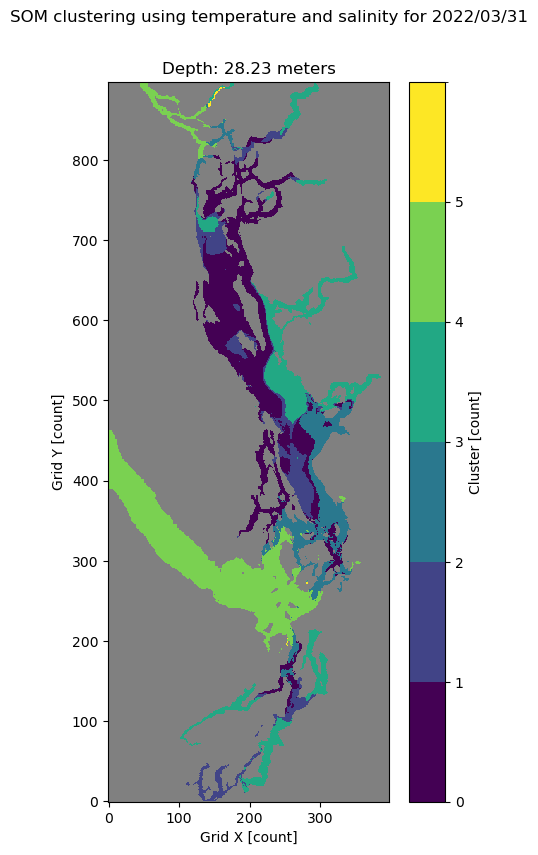

The amount of grid boxes for cluster 0 is 17780 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 7.93 degrees Celsius
The mean temperature for cluster 0 is 7.67 degrees Celsius 

The minimum salinity for cluster 0 is 29.92 g/kg
The maximum salinity for cluster 0 is 32.62 g/kg
The mean salinity for cluster 0 is 31.16 g/kg 


The amount of grid boxes for cluster 1 is 10351 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.03 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 28.49 g/kg
The maximum salinity for cluster 1 is 30.44 g/kg
The mean salinity for cluster 1 is 29.58 g/kg 


The amount of grid boxes for cluster 2 is 2531 

The minimum temperature for cluster 2 is 8.01 degrees Celsius
The maximum temperature for cluster 2 is 8.28 degrees Celsius
The mean temperature for cluster 2 is 8.07 degrees Celsius 

Th

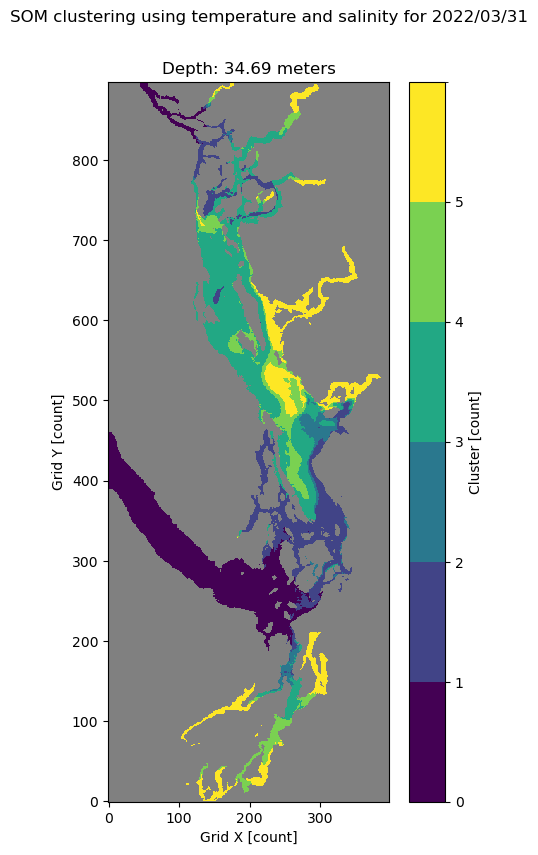

The amount of grid boxes for cluster 0 is 12295 

The minimum temperature for cluster 0 is 8.5 degrees Celsius
The maximum temperature for cluster 0 is 10.31 degrees Celsius
The mean temperature for cluster 0 is 8.87 degrees Celsius 

The minimum salinity for cluster 0 is 26.9 g/kg
The maximum salinity for cluster 0 is 30.38 g/kg
The mean salinity for cluster 0 is 29.78 g/kg 


The amount of grid boxes for cluster 1 is 12155 

The minimum temperature for cluster 1 is 8.24 degrees Celsius
The maximum temperature for cluster 1 is 8.56 degrees Celsius
The mean temperature for cluster 1 is 8.41 degrees Celsius 

The minimum salinity for cluster 1 is 27.34 g/kg
The maximum salinity for cluster 1 is 30.27 g/kg
The mean salinity for cluster 1 is 29.53 g/kg 


The amount of grid boxes for cluster 2 is 8784 

The minimum temperature for cluster 2 is 8.02 degrees Celsius
The maximum temperature for cluster 2 is 8.38 degrees Celsius
The mean temperature for cluster 2 is 8.22 degrees Celsius 

The

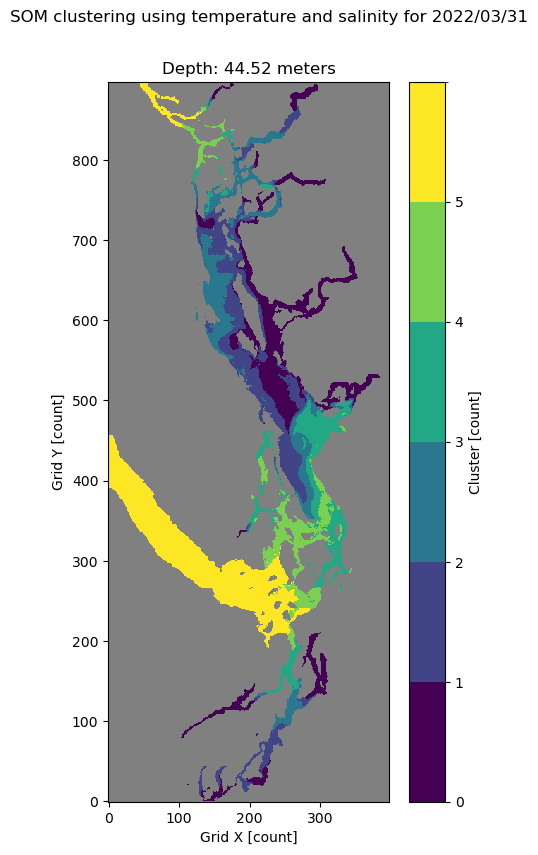

The amount of grid boxes for cluster 0 is 13041 

The minimum temperature for cluster 0 is 8.09 degrees Celsius
The maximum temperature for cluster 0 is 8.64 degrees Celsius
The mean temperature for cluster 0 is 8.43 degrees Celsius 

The minimum salinity for cluster 0 is 27.44 g/kg
The maximum salinity for cluster 0 is 30.31 g/kg
The mean salinity for cluster 0 is 29.66 g/kg 


The amount of grid boxes for cluster 1 is 14403 

The minimum temperature for cluster 1 is 8.53 degrees Celsius
The maximum temperature for cluster 1 is 10.39 degrees Celsius
The mean temperature for cluster 1 is 8.86 degrees Celsius 

The minimum salinity for cluster 1 is 27.69 g/kg
The maximum salinity for cluster 1 is 30.47 g/kg
The mean salinity for cluster 1 is 29.94 g/kg 


The amount of grid boxes for cluster 2 is 10859 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 



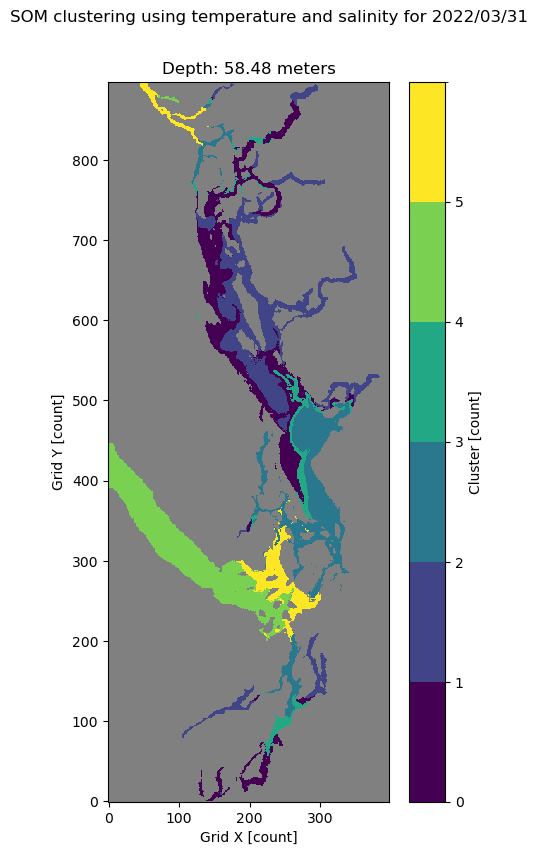

The amount of grid boxes for cluster 0 is 6208 

The minimum temperature for cluster 0 is 8.14 degrees Celsius
The maximum temperature for cluster 0 is 8.59 degrees Celsius
The mean temperature for cluster 0 is 8.44 degrees Celsius 

The minimum salinity for cluster 0 is 27.51 g/kg
The maximum salinity for cluster 0 is 30.34 g/kg
The mean salinity for cluster 0 is 29.81 g/kg 


The amount of grid boxes for cluster 1 is 17050 

The minimum temperature for cluster 1 is 8.56 degrees Celsius
The maximum temperature for cluster 1 is 10.45 degrees Celsius
The mean temperature for cluster 1 is 8.85 degrees Celsius 

The minimum salinity for cluster 1 is 27.9 g/kg
The maximum salinity for cluster 1 is 30.53 g/kg
The mean salinity for cluster 1 is 30.04 g/kg 


The amount of grid boxes for cluster 2 is 9817 

The minimum temperature for cluster 2 is 7.61 degrees Celsius
The maximum temperature for cluster 2 is 8.07 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The

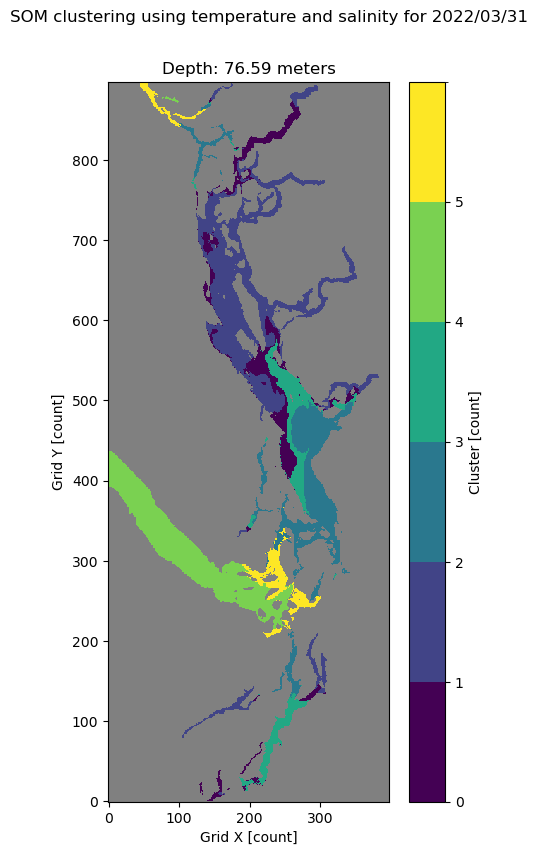

The amount of grid boxes for cluster 0 is 14941 

The minimum temperature for cluster 0 is 8.6 degrees Celsius
The maximum temperature for cluster 0 is 10.48 degrees Celsius
The mean temperature for cluster 0 is 8.95 degrees Celsius 

The minimum salinity for cluster 0 is 29.5 g/kg
The maximum salinity for cluster 0 is 30.57 g/kg
The mean salinity for cluster 0 is 30.21 g/kg 


The amount of grid boxes for cluster 1 is 3567 

The minimum temperature for cluster 1 is 8.3 degrees Celsius
The maximum temperature for cluster 1 is 8.61 degrees Celsius
The mean temperature for cluster 1 is 8.5 degrees Celsius 

The minimum salinity for cluster 1 is 27.53 g/kg
The maximum salinity for cluster 1 is 30.36 g/kg
The mean salinity for cluster 1 is 29.99 g/kg 


The amount of grid boxes for cluster 2 is 6032 

The minimum temperature for cluster 2 is 8.01 degrees Celsius
The maximum temperature for cluster 2 is 8.36 degrees Celsius
The mean temperature for cluster 2 is 8.16 degrees Celsius 

The mi

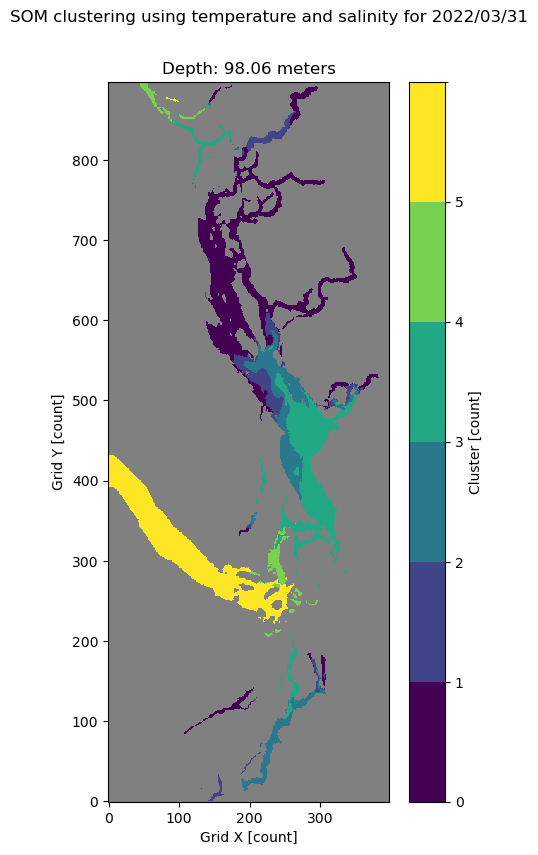

The amount of grid boxes for cluster 0 is 529 

The minimum temperature for cluster 0 is 7.49 degrees Celsius
The maximum temperature for cluster 0 is 7.68 degrees Celsius
The mean temperature for cluster 0 is 7.61 degrees Celsius 

The minimum salinity for cluster 0 is 30.94 g/kg
The maximum salinity for cluster 0 is 31.78 g/kg
The mean salinity for cluster 0 is 31.25 g/kg 


The amount of grid boxes for cluster 1 is 8815 

The minimum temperature for cluster 1 is 6.94 degrees Celsius
The maximum temperature for cluster 1 is 7.5 degrees Celsius
The mean temperature for cluster 1 is 7.18 degrees Celsius 

The minimum salinity for cluster 1 is 31.03 g/kg
The maximum salinity for cluster 1 is 33.68 g/kg
The mean salinity for cluster 1 is 33.17 g/kg 


The amount of grid boxes for cluster 2 is 2935 

The minimum temperature for cluster 2 is 8.05 degrees Celsius
The maximum temperature for cluster 2 is 8.36 degrees Celsius
The mean temperature for cluster 2 is 8.19 degrees Celsius 

The mi

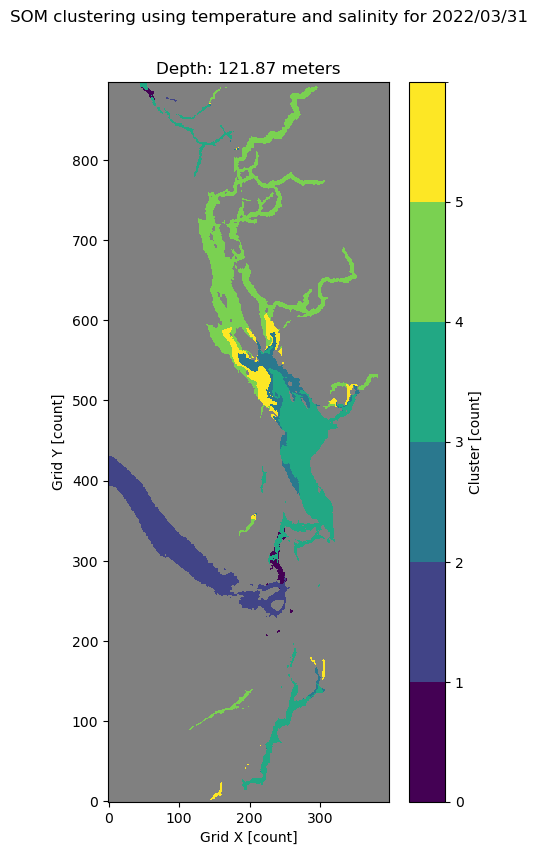

The amount of grid boxes for cluster 0 is 2091 

The minimum temperature for cluster 0 is 8.42 degrees Celsius
The maximum temperature for cluster 0 is 8.72 degrees Celsius
The mean temperature for cluster 0 is 8.58 degrees Celsius 

The minimum salinity for cluster 0 is 28.18 g/kg
The maximum salinity for cluster 0 is 30.61 g/kg
The mean salinity for cluster 0 is 30.45 g/kg 


The amount of grid boxes for cluster 1 is 12236 

The minimum temperature for cluster 1 is 8.72 degrees Celsius
The maximum temperature for cluster 1 is 10.78 degrees Celsius
The mean temperature for cluster 1 is 9.1 degrees Celsius 

The minimum salinity for cluster 1 is 29.81 g/kg
The maximum salinity for cluster 1 is 30.87 g/kg
The mean salinity for cluster 1 is 30.54 g/kg 


The amount of grid boxes for cluster 2 is 9788 

The minimum temperature for cluster 2 is 7.51 degrees Celsius
The maximum temperature for cluster 2 is 8.15 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

The

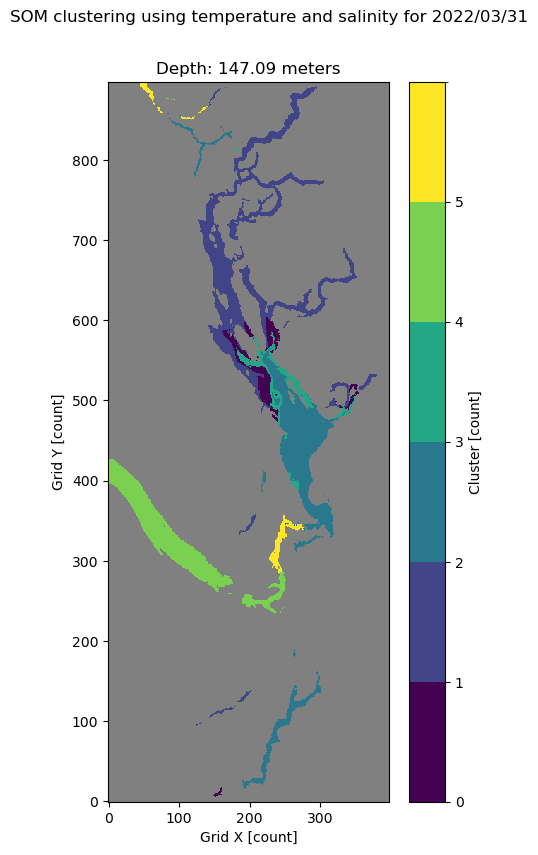

The amount of grid boxes for cluster 0 is 1329 

The minimum temperature for cluster 0 is 8.53 degrees Celsius
The maximum temperature for cluster 0 is 8.84 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 28.23 g/kg
The maximum salinity for cluster 0 is 30.77 g/kg
The mean salinity for cluster 0 is 30.62 g/kg 


The amount of grid boxes for cluster 1 is 11712 

The minimum temperature for cluster 1 is 8.83 degrees Celsius
The maximum temperature for cluster 1 is 10.8 degrees Celsius
The mean temperature for cluster 1 is 9.15 degrees Celsius 

The minimum salinity for cluster 1 is 29.83 g/kg
The maximum salinity for cluster 1 is 30.92 g/kg
The mean salinity for cluster 1 is 30.66 g/kg 


The amount of grid boxes for cluster 2 is 7752 

The minimum temperature for cluster 2 is 7.61 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 8.0 degrees Celsius 

The 

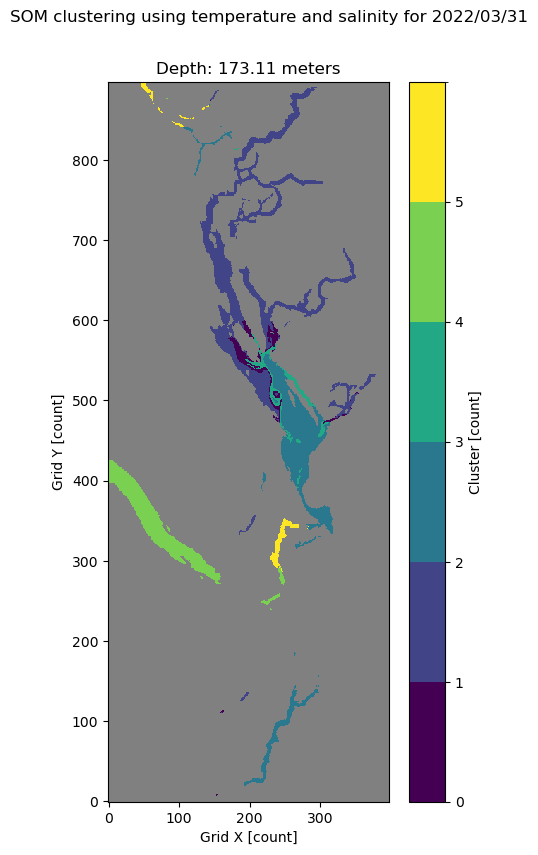

The amount of grid boxes for cluster 0 is 2389 

The minimum temperature for cluster 0 is 6.56 degrees Celsius
The maximum temperature for cluster 0 is 7.57 degrees Celsius
The mean temperature for cluster 0 is 6.9 degrees Celsius 

The minimum salinity for cluster 0 is 31.41 g/kg
The maximum salinity for cluster 0 is 33.9 g/kg
The mean salinity for cluster 0 is 33.62 g/kg 


The amount of grid boxes for cluster 1 is 2110 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 8.04 degrees Celsius
The mean temperature for cluster 1 is 7.77 degrees Celsius 

The minimum salinity for cluster 1 is 29.15 g/kg
The maximum salinity for cluster 1 is 31.41 g/kg
The mean salinity for cluster 1 is 30.45 g/kg 


The amount of grid boxes for cluster 2 is 4184 

The minimum temperature for cluster 2 is 8.03 degrees Celsius
The maximum temperature for cluster 2 is 8.51 degrees Celsius
The mean temperature for cluster 2 is 8.25 degrees Celsius 

The mi

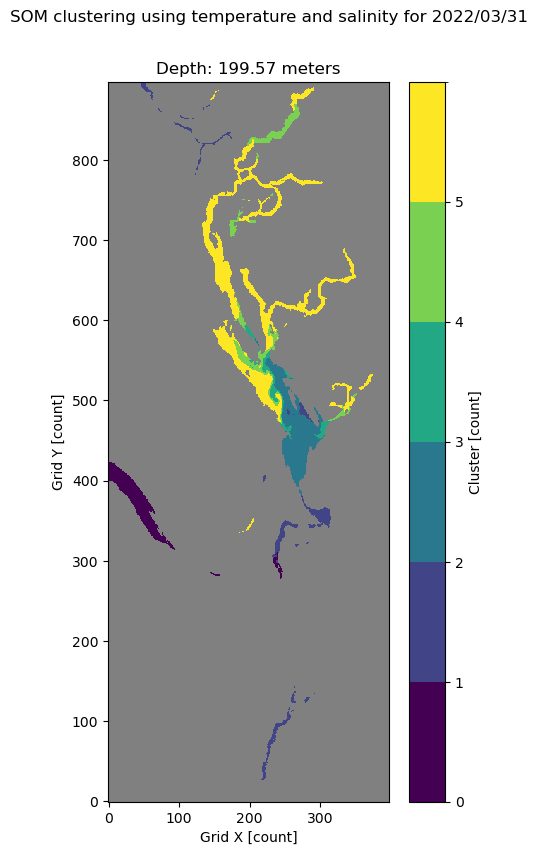

The amount of grid boxes for cluster 0 is 1639 

The minimum temperature for cluster 0 is 7.6 degrees Celsius
The maximum temperature for cluster 0 is 8.37 degrees Celsius
The mean temperature for cluster 0 is 8.17 degrees Celsius 

The minimum salinity for cluster 0 is 29.73 g/kg
The maximum salinity for cluster 0 is 30.86 g/kg
The mean salinity for cluster 0 is 30.6 g/kg 


The amount of grid boxes for cluster 1 is 1573 

The minimum temperature for cluster 1 is 6.45 degrees Celsius
The maximum temperature for cluster 1 is 7.68 degrees Celsius
The mean temperature for cluster 1 is 7.0 degrees Celsius 

The minimum salinity for cluster 1 is 30.25 g/kg
The maximum salinity for cluster 1 is 33.95 g/kg
The mean salinity for cluster 1 is 32.99 g/kg 


The amount of grid boxes for cluster 2 is 2415 

The minimum temperature for cluster 2 is 8.37 degrees Celsius
The maximum temperature for cluster 2 is 8.87 degrees Celsius
The mean temperature for cluster 2 is 8.55 degrees Celsius 

The min

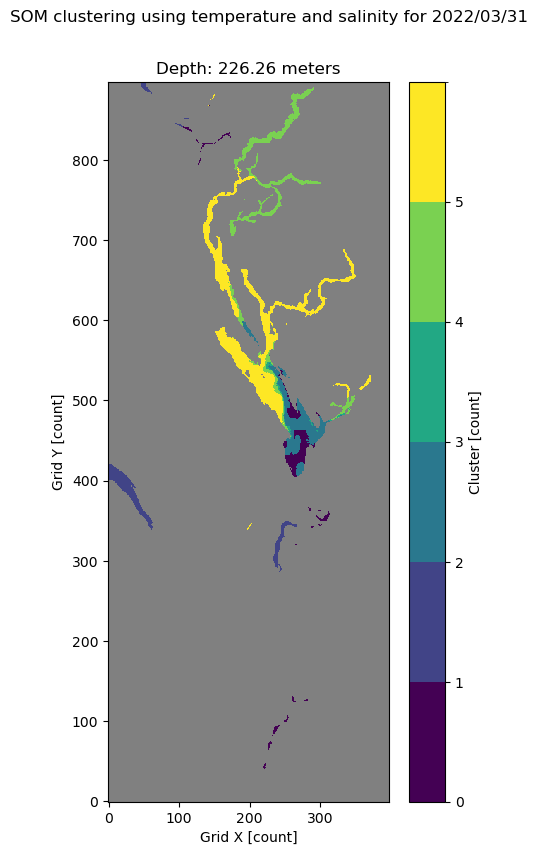

The amount of grid boxes for cluster 0 is 887 

The minimum temperature for cluster 0 is 9.12 degrees Celsius
The maximum temperature for cluster 0 is 9.24 degrees Celsius
The mean temperature for cluster 0 is 9.19 degrees Celsius 

The minimum salinity for cluster 0 is 30.61 g/kg
The maximum salinity for cluster 0 is 31.06 g/kg
The mean salinity for cluster 0 is 30.83 g/kg 


The amount of grid boxes for cluster 1 is 5910 

The minimum temperature for cluster 1 is 9.23 degrees Celsius
The maximum temperature for cluster 1 is 9.69 degrees Celsius
The mean temperature for cluster 1 is 9.33 degrees Celsius 

The minimum salinity for cluster 1 is 30.62 g/kg
The maximum salinity for cluster 1 is 31.08 g/kg
The mean salinity for cluster 1 is 30.97 g/kg 


The amount of grid boxes for cluster 2 is 763 

The minimum temperature for cluster 2 is 8.74 degrees Celsius
The maximum temperature for cluster 2 is 8.96 degrees Celsius
The mean temperature for cluster 2 is 8.84 degrees Celsius 

The mi

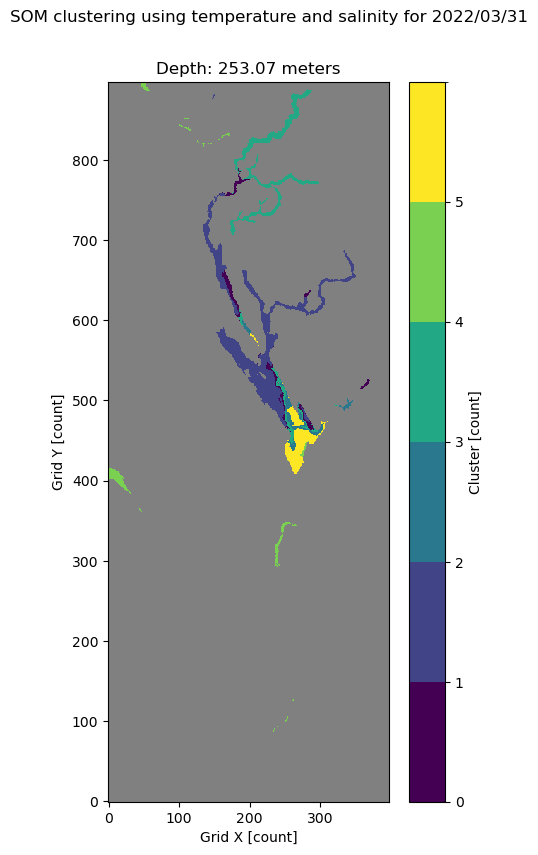

The amount of grid boxes for cluster 0 is 205 

The minimum temperature for cluster 0 is 8.72 degrees Celsius
The maximum temperature for cluster 0 is 8.91 degrees Celsius
The mean temperature for cluster 0 is 8.82 degrees Celsius 

The minimum salinity for cluster 0 is 30.6 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.92 g/kg 


The amount of grid boxes for cluster 1 is 1046 

The minimum temperature for cluster 1 is 6.39 degrees Celsius
The maximum temperature for cluster 1 is 8.72 degrees Celsius
The mean temperature for cluster 1 is 8.22 degrees Celsius 

The minimum salinity for cluster 1 is 29.83 g/kg
The maximum salinity for cluster 1 is 33.97 g/kg
The mean salinity for cluster 1 is 31.13 g/kg 


The amount of grid boxes for cluster 2 is 605 

The minimum temperature for cluster 2 is 9.1 degrees Celsius
The maximum temperature for cluster 2 is 9.21 degrees Celsius
The mean temperature for cluster 2 is 9.16 degrees Celsius 

The minim

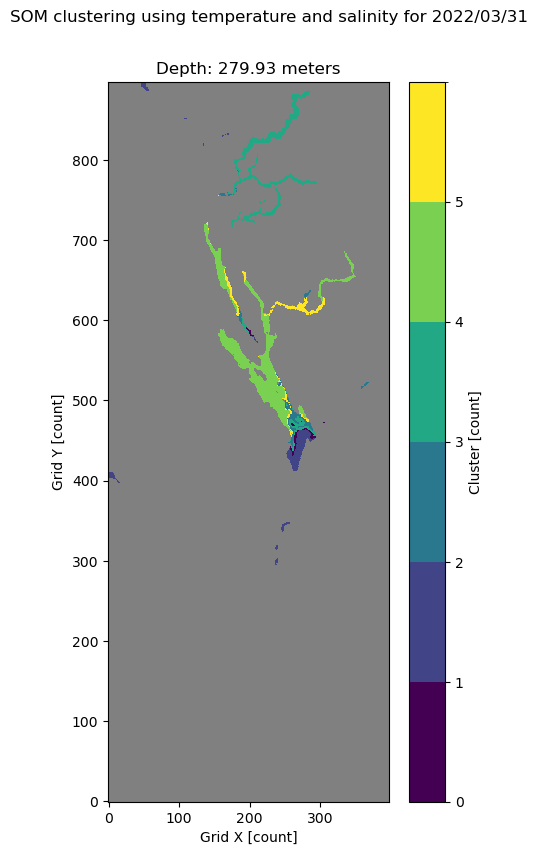

The amount of grid boxes for cluster 0 is 660 

The minimum temperature for cluster 0 is 7.53 degrees Celsius
The maximum temperature for cluster 0 is 8.92 degrees Celsius
The mean temperature for cluster 0 is 8.5 degrees Celsius 

The minimum salinity for cluster 0 is 29.84 g/kg
The maximum salinity for cluster 0 is 31.59 g/kg
The mean salinity for cluster 0 is 30.97 g/kg 


The amount of grid boxes for cluster 1 is 2119 

The minimum temperature for cluster 1 is 8.92 degrees Celsius
The maximum temperature for cluster 1 is 9.1 degrees Celsius
The mean temperature for cluster 1 is 9.01 degrees Celsius 

The minimum salinity for cluster 1 is 30.66 g/kg
The maximum salinity for cluster 1 is 31.06 g/kg
The mean salinity for cluster 1 is 30.72 g/kg 


The amount of grid boxes for cluster 2 is 211 

The minimum temperature for cluster 2 is 9.07 degrees Celsius
The maximum temperature for cluster 2 is 9.2 degrees Celsius
The mean temperature for cluster 2 is 9.15 degrees Celsius 

The minim

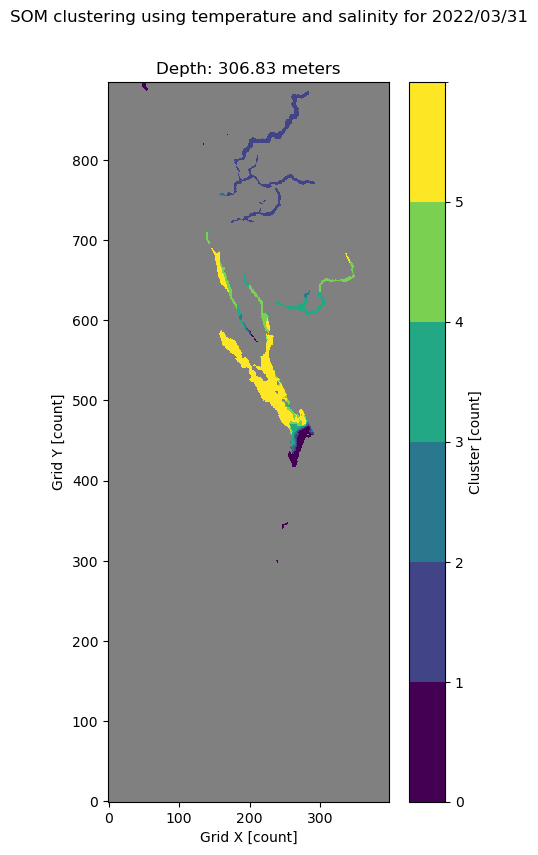

The amount of grid boxes for cluster 0 is 652 

The minimum temperature for cluster 0 is 7.6 degrees Celsius
The maximum temperature for cluster 0 is 9.0 degrees Celsius
The mean temperature for cluster 0 is 8.79 degrees Celsius 

The minimum salinity for cluster 0 is 30.57 g/kg
The maximum salinity for cluster 0 is 31.23 g/kg
The mean salinity for cluster 0 is 30.83 g/kg 


The amount of grid boxes for cluster 1 is 1510 

The minimum temperature for cluster 1 is 8.99 degrees Celsius
The maximum temperature for cluster 1 is 9.14 degrees Celsius
The mean temperature for cluster 1 is 9.03 degrees Celsius 

The minimum salinity for cluster 1 is 30.69 g/kg
The maximum salinity for cluster 1 is 31.07 g/kg
The mean salinity for cluster 1 is 30.73 g/kg 


The amount of grid boxes for cluster 2 is 474 

The minimum temperature for cluster 2 is 9.11 degrees Celsius
The maximum temperature for cluster 2 is 9.25 degrees Celsius
The mean temperature for cluster 2 is 9.21 degrees Celsius 

The mini

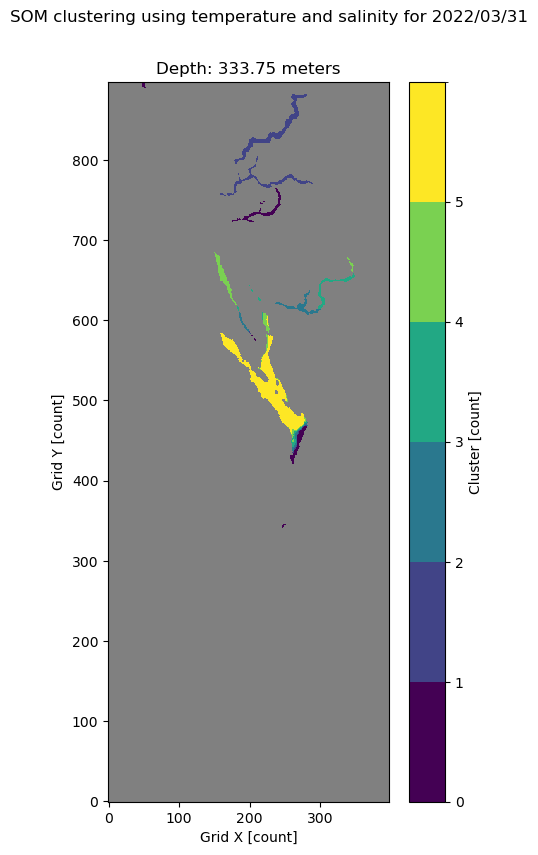

The amount of grid boxes for cluster 0 is 1462 

The minimum temperature for cluster 0 is 8.9 degrees Celsius
The maximum temperature for cluster 0 is 9.06 degrees Celsius
The mean temperature for cluster 0 is 9.0 degrees Celsius 

The minimum salinity for cluster 0 is 30.67 g/kg
The maximum salinity for cluster 0 is 31.05 g/kg
The mean salinity for cluster 0 is 30.72 g/kg 


The amount of grid boxes for cluster 1 is 200 

The minimum temperature for cluster 1 is 9.04 degrees Celsius
The maximum temperature for cluster 1 is 9.12 degrees Celsius
The mean temperature for cluster 1 is 9.07 degrees Celsius 

The minimum salinity for cluster 1 is 30.72 g/kg
The maximum salinity for cluster 1 is 31.08 g/kg
The mean salinity for cluster 1 is 30.76 g/kg 


The amount of grid boxes for cluster 2 is 359 

The minimum temperature for cluster 2 is 9.13 degrees Celsius
The maximum temperature for cluster 2 is 9.26 degrees Celsius
The mean temperature for cluster 2 is 9.22 degrees Celsius 

The mini

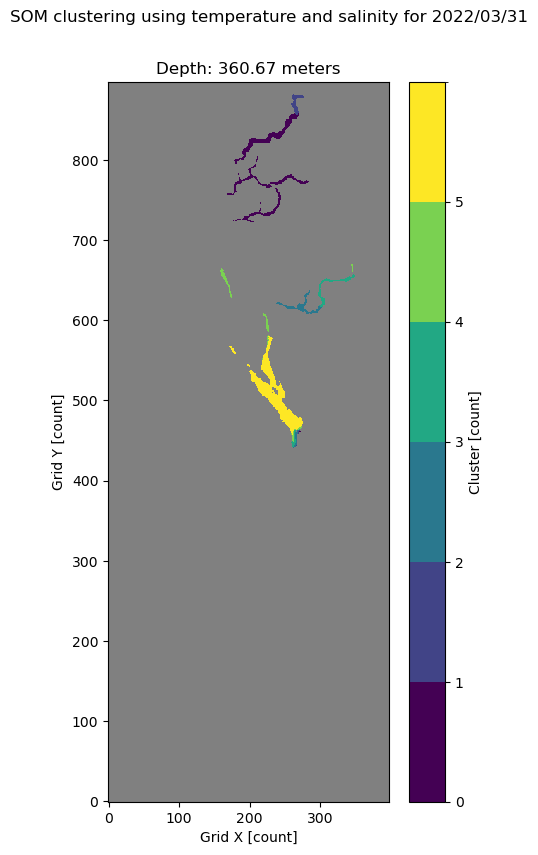

The amount of grid boxes for cluster 0 is 1173 

The minimum temperature for cluster 0 is 8.92 degrees Celsius
The maximum temperature for cluster 0 is 9.06 degrees Celsius
The mean temperature for cluster 0 is 9.0 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 30.77 g/kg
The mean salinity for cluster 0 is 30.72 g/kg 


The amount of grid boxes for cluster 1 is 233 

The minimum temperature for cluster 1 is 9.06 degrees Celsius
The maximum temperature for cluster 1 is 9.08 degrees Celsius
The mean temperature for cluster 1 is 9.07 degrees Celsius 

The minimum salinity for cluster 1 is 30.73 g/kg
The maximum salinity for cluster 1 is 30.74 g/kg
The mean salinity for cluster 1 is 30.74 g/kg 


The amount of grid boxes for cluster 2 is 216 

The minimum temperature for cluster 2 is 9.2 degrees Celsius
The maximum temperature for cluster 2 is 9.23 degrees Celsius
The mean temperature for cluster 2 is 9.21 degrees Celsius 

The mini

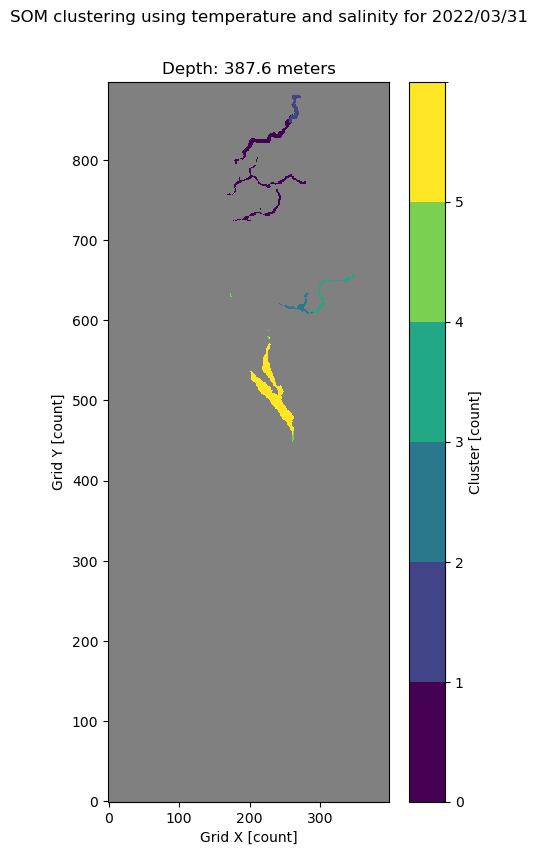

The amount of grid boxes for cluster 0 is 58 

The minimum temperature for cluster 0 is 9.3 degrees Celsius
The maximum temperature for cluster 0 is 9.3 degrees Celsius
The mean temperature for cluster 0 is 9.3 degrees Celsius 

The minimum salinity for cluster 0 is 31.13 g/kg
The maximum salinity for cluster 0 is 31.13 g/kg
The mean salinity for cluster 0 is 31.13 g/kg 


The amount of grid boxes for cluster 1 is 677 

The minimum temperature for cluster 1 is 9.42 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.44 degrees Celsius 

The minimum salinity for cluster 1 is 31.13 g/kg
The maximum salinity for cluster 1 is 31.18 g/kg
The mean salinity for cluster 1 is 31.17 g/kg 


The amount of grid boxes for cluster 3 is 934 

The minimum temperature for cluster 3 is 9.2 degrees Celsius
The maximum temperature for cluster 3 is 9.3 degrees Celsius
The mean temperature for cluster 3 is 9.24 degrees Celsius 

The minimum s

IndexError: index 5 is out of bounds for axis 0 with size 5

In [7]:
ds, temp, saline, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline = masking(depth, temp, saline, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
